# Autoencoder

In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl

In [23]:
batch_size = 256
learning_rate = 0.0002
num_epochs = 10

## 2. Data

In [24]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

In [25]:
dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataloaders['val'] = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

## 3. Model & Optimizer

In [26]:

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 100),    
            nn.ReLU(),                          
            nn.Linear(100, 30),
            nn.ReLU()                          
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(30, 100),
            nn.ReLU(),                          
            nn.Linear(100, 784),
            nn.ReLU()             
        )

                
    def forward(self, x):                
        batch_size = x.size(0)
        x = x.reshape(-1,28*28)                          
        encoded = self.encoder(x)                    
        out = self.decoder(encoded)                       
        return out, encoded


In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [28]:
model = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 4. Train 

In [29]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs):

    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)


        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()            
            else:
                model.eval()            

            running_loss = 0.0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)                                       
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):

                    outputs, encoded = model(inputs)
                    loss = loss_func(outputs, inputs.reshape(-1,784))                         
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()  
                running_loss += loss.item() * inputs.size(0)                    

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            
            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [30]:
best_model, train_loss_history, val_loss_history = train_model(model, dataloaders, loss_func, optimizer, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.0749
val Loss: 0.0556

Epoch 1/9
----------
train Loss: 0.0437
val Loss: 0.0365

Epoch 2/9
----------
train Loss: 0.0329
val Loss: 0.0306

Epoch 3/9
----------
train Loss: 0.0288
val Loss: 0.0277

Epoch 4/9
----------
train Loss: 0.0265
val Loss: 0.0259

Epoch 5/9
----------
train Loss: 0.0251
val Loss: 0.0249

Epoch 6/9
----------
train Loss: 0.0242
val Loss: 0.0241

Epoch 7/9
----------
train Loss: 0.0236
val Loss: 0.0235

Epoch 8/9
----------
train Loss: 0.0231
val Loss: 0.0231

Epoch 9/9
----------
train Loss: 0.0228
val Loss: 0.0228

Training complete in 0m 22s
Best val Loss: 0.022827


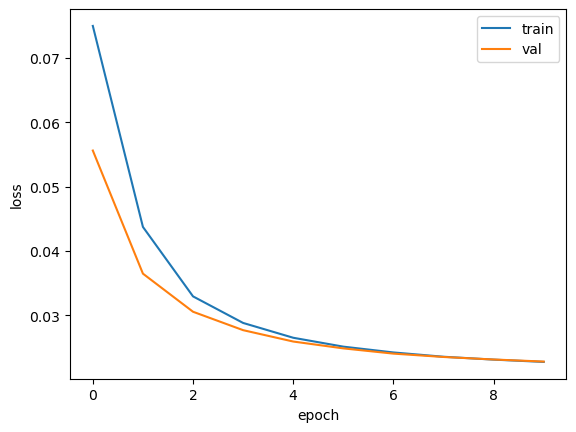

In [31]:
# Let's draw a learning curve like below.
plt.plot(train_loss_history, label="train")
plt.plot(val_loss_history, label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [32]:
with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)

        outputs, encoded = best_model(inputs)
        test_loss = loss_func(outputs, inputs.reshape(-1,784))
        
        running_loss += test_loss.item() * inputs.size(0)

    test_loss = running_loss / len(dataloaders["test"].dataset)
    print(test_loss)        

0.0224162281870842


torch.Size([16, 28, 28])


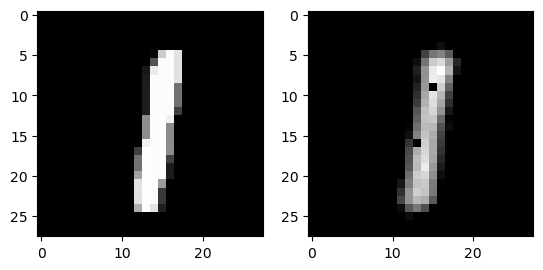

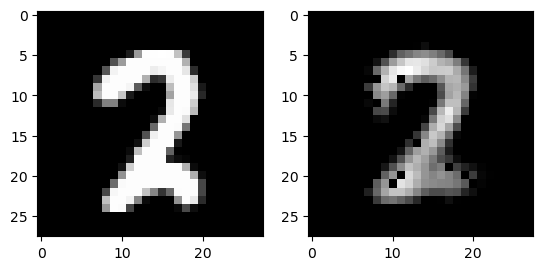

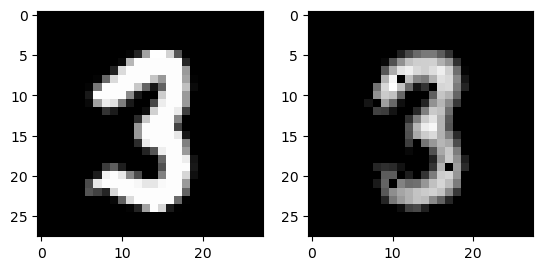

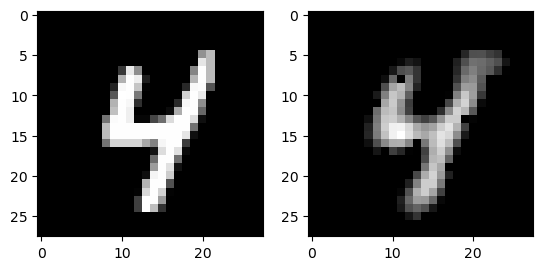

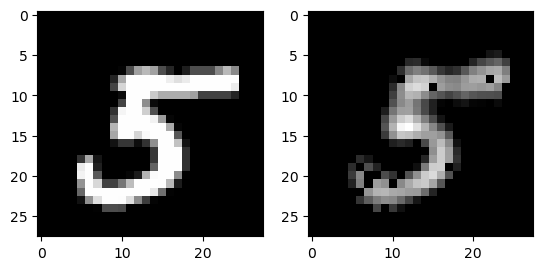

In [33]:
out_img = (outputs.cpu().data).reshape(-1,28,28)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()